# HarvestStat Data Profiling - Niger

In [1]:
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import retreive_fdw_data, save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Set loading parameters ------------------------ #
country_name = 'Niger'
country_iso2 = 'NE'
use_api_data = False
requires_authentication = False
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32631' # Niger
fn_shapes = sorted(glob.glob(f"../data/shapefile/fewsnet/{country_iso2}_Admin?_????.shp"))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
# PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# Load FDW data -------------------------------- #
df = retreive_fdw_data(country_name, country_iso2, use_api_data, requires_authentication)
# ----------------------------------------------- #

Data is loaded from the local file.
../data/crop_raw_data/adm_crop_data_raw_NE.csv is loaded.


In [3]:
###################################################
# The current submitted data has an issue on start_date. Here we manually correct it.
idx = df['start_date'].apply(lambda x: x[-5:]) == '10-01'
df.loc[idx, 'start_date'] = df.loc[idx, 'start_date'].apply(lambda x: x[:-5] + '12-01')
###################################################

###################################################
# The latest data includes admin3 level data. We will include this later.
df['admin_level'] = df['fnid'].apply(lambda x: x[6:8])
df = df[df['admin_level'] != 'A3']
###################################################

# Shape file correction
# Correct the 2012 admin file for Nigeria to include Agadez Commune
NE_Admin2_2012.loc[NE_Admin2_2012.FNID=='NE2012A20109','ADMIN2'] = 'Agadez Commune'
NE_Admin2_2012.loc[NE_Admin2_2012.FNID=='NE2012A20109','ADMIN2FR'] = 'Agadez Commune'
NE_Admin2_2012.loc[NE_Admin2_2012.FNID=='NE2012A20109','ALIASES'] = 'None'

# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# 2. Manual correction
# a) Season name
df.loc[df['season_name'] == 'Main season', 'season_name'] = 'Main'
# b) order of magnitude error in Agadaz commune right after it was creted
df.loc[(df.fnid=='NE2012A20109')&(pd.to_datetime(df.season_date).dt.year==2013)&(df.indicator=='Area Planted'),'value'] = \
df.loc[(df.fnid=='NE2012A20109')&(pd.to_datetime(df.season_date).dt.year==2013)&(df.indicator=='Area Planted'),'value']/10
df.loc[(df.fnid=='NE2012A20109')&(pd.to_datetime(df.season_date).dt.year==2013)&(df.indicator=='Quantity Produced'),'value'] = \
df.loc[(df.fnid=='NE2012A20109')&(pd.to_datetime(df.season_date).dt.year==2013)&(df.indicator=='Quantity Produced'),'value']/10

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df)
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([NE_Admin2_1972,NE_Admin2_1992,NE_Admin2_2001,NE_Admin2_2012,NE_Admin2_2018], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 90,500
Removed 38,961 "Missing Value" points
17,239/22,625 "Area Harvested" points are retained.
0/22,625 "Area Planted" points are retained.
17,164/22,625 "Quantity Produced" points are retained.
17,136/22,625 "Yield" points are retained.


Current data points: 51,539



- Minor changes are applied ------------------- #

- Basic information --------------------------- #


Data period: 1980 - 2022
43 grain types are found: Anise, Bambara groundnut, Basil, Bean (Hyacinth), Cabbage (Unspecified), Capsicum chinense, unspecified, Carrots, Cassava, Celery, Chili pepper (Unspecified), Coriander, Cotton (Unspecified), Cowpea (unspecified), Cucumber, Eggplant, Fonio, Garlic (fresh), Gourd (Unspecified), Groundnuts (In Shell), Henna, Lettuce (Unspecified), Maize (Corn), Melon (unspecified), Millet, Okras (Fresh), Onions, Pea (unspecified), Potato (unspecified), Rape fodder, Rice (Paddy), Sesame Seed, Sorghum, Sorrel, Squash (Pumpkin, Zucchini), Squash (Unspecified), Sugarcane (for sugar), Sweet Potatoes, Tigernut, Tobacco (unspecified), Tomato, Tomatoes (Roma, medium), Watermelon, Wheat Grain
2 seasons are found: Main (06-01), Dry (10-01)
4 crop production system are found: Rainfed (PS), All (PS), irrigated, ONAHA (PS)
Data sources include:
[1] Ministere de l'Agriculture, Niger --- Official agricultural statistics, Niger
Administrative-1 fnids: 0
Administrative-2

- Recorded years per season ------------------- #
Main: 43 years (1980-2022) (missing: 0 years)
Dry: 12 years (2010-2021) (missing: 0 years)

- Number of "Quantity Produced" data points --- #
NE1972A2: 1,248 data points are found.
NE1992A2: 1,184 data points are found.
NE2001A2: 2,898 data points are found.
NE2012A2: 8,294 data points are found.
NE2018A2: 3,540 data points are found.

- Districts with population group(s) ---------- #
0 districts includes 'population_group'.



Table of available data


----------------------------------------------- #
Crop type: Anise
----------------------------------------------- #
season_name                  Dry       
crop_production_system irrigated       
fnid_short                2012A2 2018A2
year                                   
2012                        1/74    NaN
2013                         NaN    NaN
2014                        1/74    NaN
2015                        1/74    NaN
2016                        1/74    NaN
2017                        2/74    NaN
2018                         NaN   2/67
----------------------------------------------- #
Crop type: Bambara groundnut
----------------------------------------------- #
season_name                    Main                     
crop_production_system Rainfed (PS)                     
fnid_short                   1992A2 2001A2 2012A2 2018A2
year                                                    
1992                           1/36    NaN    NaN    NaN
1993                         

season_name                  Dry                       Main              
crop_production_system irrigated               Rainfed (PS)              
fnid_short                2001A2 2012A2 2018A2       2001A2 2012A2 2018A2
year                                                                     
2009                         NaN    NaN    NaN         1/37    NaN    NaN
2010                        6/37    NaN    NaN          NaN    NaN    NaN
2011                       31/37    NaN    NaN          NaN    NaN    NaN
2012                         NaN  49/74    NaN          NaN    NaN    NaN
2013                         NaN  42/74    NaN          NaN    NaN    NaN
2014                         NaN  29/74    NaN          NaN    NaN    NaN
2015                         NaN  29/74    NaN          NaN    NaN    NaN
2016                         NaN  40/74    NaN          NaN    NaN    NaN
2017                         NaN  39/74    NaN          NaN  11/74    NaN
2018                         NaN   1/7

../figures/NE_admin_shapes.png is saved.


- Niger crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-niger.png?itok=UBgvvRXP"  width=900><br>

<img src="https://ipad.fas.usda.gov/rssiws/al/crop_calendar/images/wafrica_ng_calendar.png"  width=900>

- comparison of boundaries

<img src="../figures/NE_admin_shapes.png"  width=900>

- In Niger, basd on the FEWS NET data, there were four times of changes in administrative units: 1972, 1992, 2012, and 2018.

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1972	 | NE1972A1 | 7	| NE1972A2	| 35	|
| 1992	 | NE1992A1 | 8	| NE1992A2	| 36	|
| 2001	 | NE2001A1 | 8	| NE2001A2	| 37	|
| 2012	 | NE2012A1 | 8	| NE2012A2	| 74	|
| 2018	 | NE2018A1 | 8	| NE2018A2	| 67	|

- The data is all reported in a single main season
- While there is a shapefile for 2018, there is no crop data associated with the 2018 shapefile, so we use 2012 as the most recent shapefile

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = NE_Admin2_2012.copy().to_crs('epsg:32631')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

NE2001A20704:	"Matameye" (FDW) is changed to "Kantche" (shapefile).
NE2012A20311:	"Dioundiou" (FDW) is changed to "Dioudiou" (shapefile).


In [5]:
# Link admin boundaries ------------------------- #
link_2001, over_2001 = FDW_PD_CreateAdminLink(NE_Admin2_2001, NE_Admin2_2012, 'ADMIN2', 'ADMIN2', prod, epsg)
#assert all(np.unique([v['method'] for k,v in link_2001.items()]) == 'PBR')
link_1992, over_1992 = FDW_PD_CreateAdminLink(NE_Admin2_1992, NE_Admin2_2012, 'ADMIN2', 'ADMIN2', prod, epsg)
#assert all(np.unique([v['method'] for k,v in link_1992.items()]) == 'PBR')
link_1972, over_1972 = FDW_PD_CreateAdminLink(NE_Admin2_1972, NE_Admin2_2012, 'ADMIN2', 'ADMIN2', prod, epsg)
#assert all(np.unique([v['method'] for k,v in link_1972.items()]) == 'PBR')


# Crop specific ratios
link_ratio_1972 = FDW_PD_RatioAdminLink(link_1972, prod, over_1972, mdx_pss)
link_ratio_1992 = FDW_PD_RatioAdminLink(link_1992, prod, over_1992, mdx_pss)
link_ratio_2001 = FDW_PD_RatioAdminLink(link_2001, prod, over_2001, mdx_pss)

# Merge link_ratio
assert link_ratio_1992.keys() == link_ratio_2001.keys()
assert link_ratio_1972.keys() == link_ratio_2001.keys()

link_merged = [link_ratio_1972, link_ratio_1992, link_ratio_2001]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

CBR is considered for 'NE2001A20101' as no record found in: ['NE2012A20109']
CBR is considered for 'NE2001A20201' as no record found in: ['NE2012A20210']
CBR is considered for 'NE2001A20203' as no record found in: ['NE2012A20209']


CBR is considered for 'NE2001A20601' as no record found in: ['NE2012A20619']
CBR is considered for 'NE2001A20801' as no record found in: ['NE2012A20802', 'NE2012A20803', 'NE2012A20804', 'NE2012A20805', 'NE2012A20806']


CBR is considered for 'NE1992A20101' as no record found in: ['NE2012A20109']
CBR is considered for 'NE1992A20201' as no record found in: ['NE2012A20210']
CBR is considered for 'NE1992A20203' as no record found in: ['NE2012A20209']


CBR is considered for 'NE1992A20601' as no record found in: ['NE2012A20619']
CBR is considered for 'NE1992A20801' as no record found in: ['NE2012A20802', 'NE2012A20803', 'NE2012A20804', 'NE2012A20805', 'NE2012A20806']


CBR is considered for 'NE1972A20101' as no record found in: ['NE2012A20109']
CBR is considered for 'NE1972A20203' as no record found in: ['NE2012A20209']


CBR is considered for 'NE1972A20901' as no record found in: ['NE2012A20619']
CBR is considered for 'NE1972A20201' as no record found in: ['NE2012A20210']
CBR is considered for 'NE1972A20903' as no record found in: ['NE2012A20802', 'NE2012A20803', 'NE2012A20804', 'NE2012A20805', 'NE2012A20806']


In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
#I need to be able to look at the source docs here. I think maize planted area was used
#area_new.loc[2019,pd.IndexSlice['NE2012A20804',:,'Millet','Main season',:,:,'none']] = 2000
#area_new.loc[2019,pd.IndexSlice['NE2012A20805',:,'Millet','Main season',:,:,'none']] = 4000

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

All [country, season_name] are in the external season calendar.


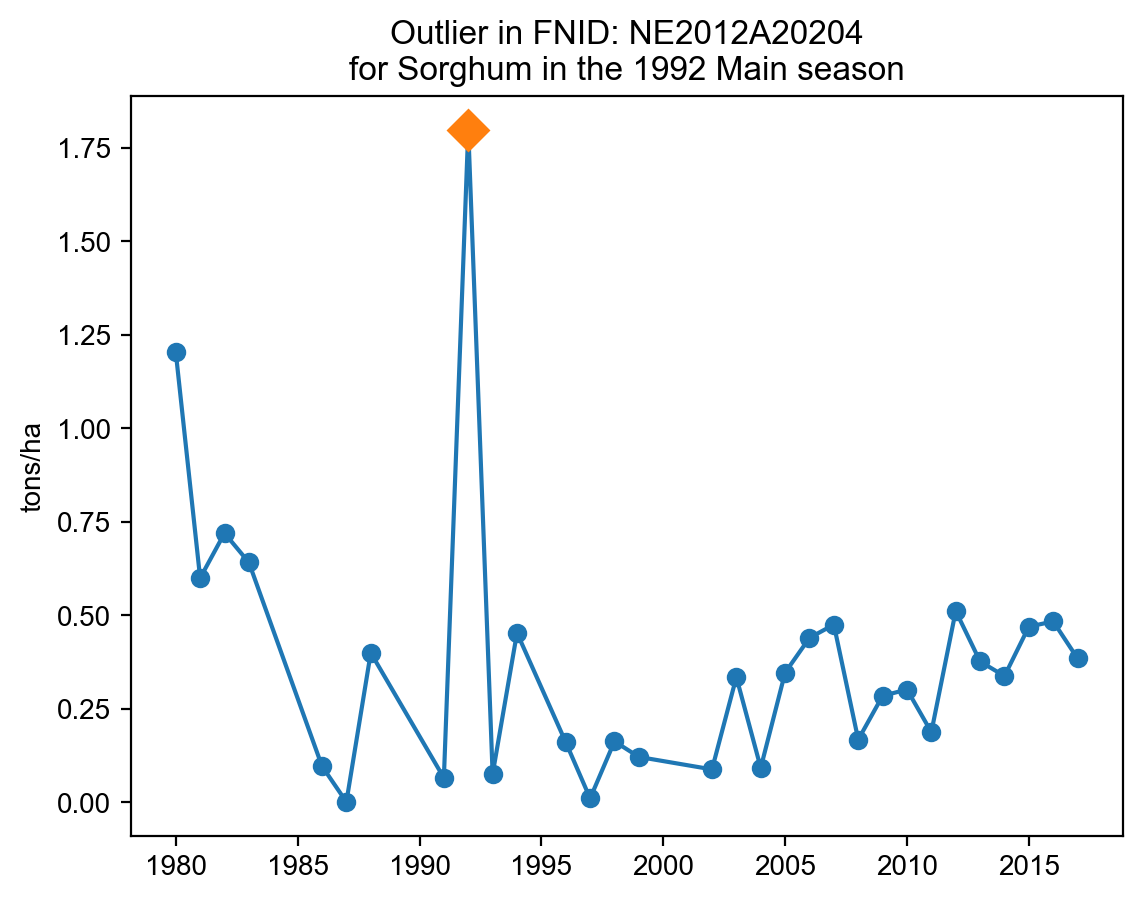

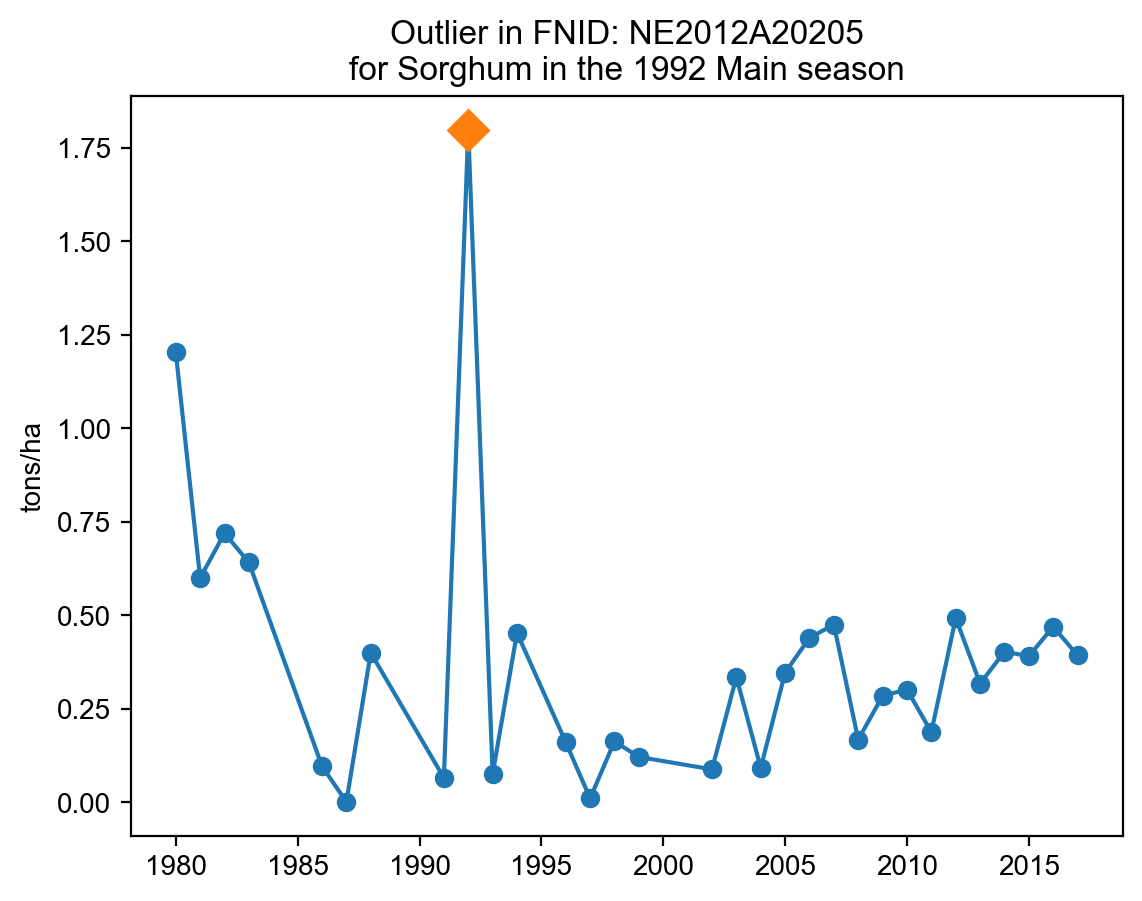

In [7]:
from matplotlib import pyplot as plt

outliers = [
            #['NE2012A20804','Millet','Main',2019],
            #['NE2012A20805','Millet','Main',2019],
            ['NE2012A20204','Sorghum','Main',1992],
            ['NE2012A20205','Sorghum','Main',1992],
            #['NE2012A20210','Sorghum','Main',1992],
            #['NE2012A20619','Sorghum','Main',2014],
            #['NE2012A20511','Groundnuts','Main',1996],
            #['NE2012A20510','Groundnuts','Main',1996],
           ]
stack=stack.sort_values(by='harvest_year')

#first plot, then remove the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title('Outlier in FNID: '+iou[0]+'\nfor '+iou[1]+' in the '+str(iou[3])+' '+iou[2]+' season')
    plt.ylabel('tons/ha')
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1   
   

In [8]:
# Save data
fn_out = '../data/crop/adm_crop_production_NE.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_NE_ratio.npz', link_ratio)

../data/crop/adm_crop_production_NE.csv is saved.
../data/crop/adm_crop_production_NE_ratio.npz is saved.


## Visualization of production data

/Users/dlee/harveststat-africa/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


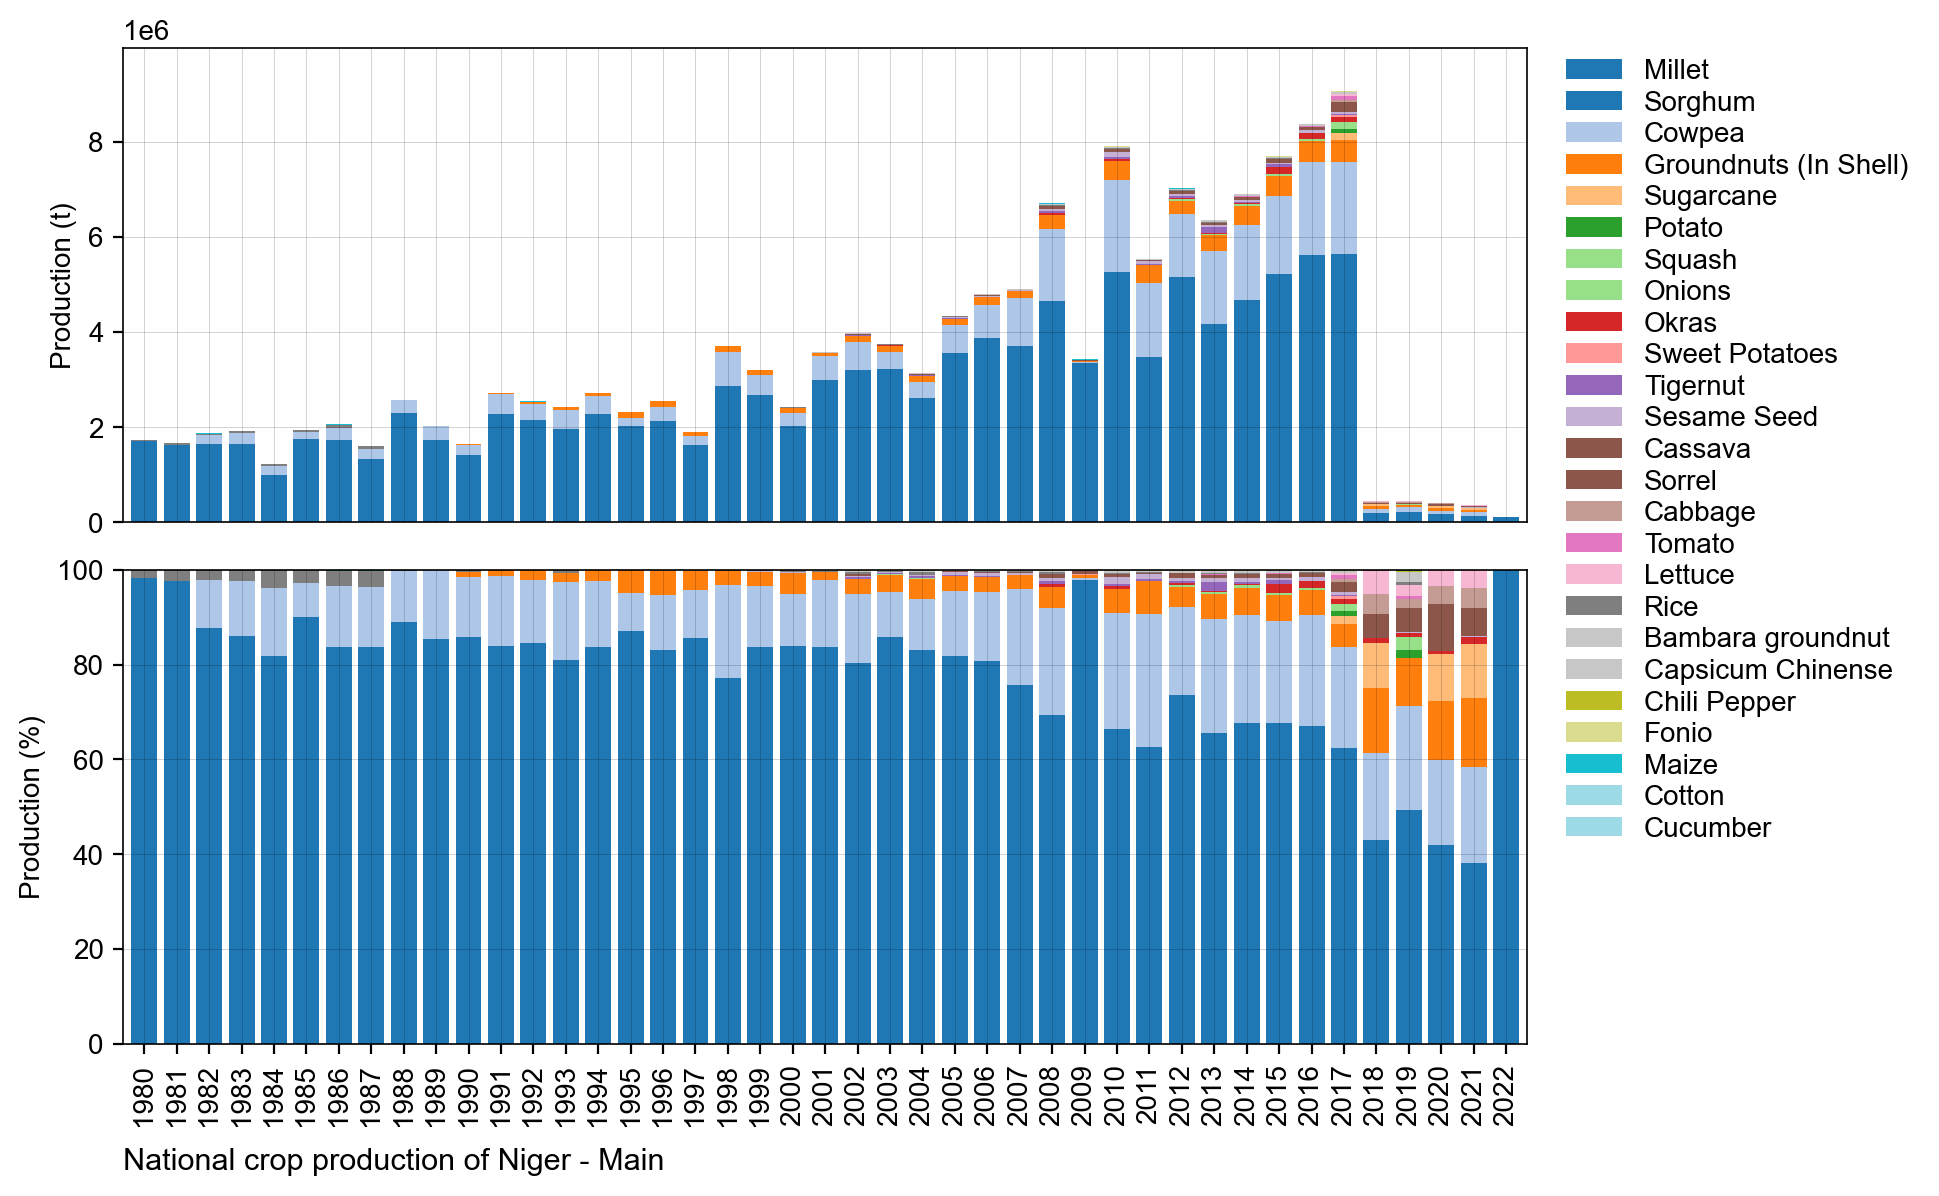

../figures/NE_bar_natgrainprod_Main.png is saved.


/Users/dlee/harveststat-africa/notebook/tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


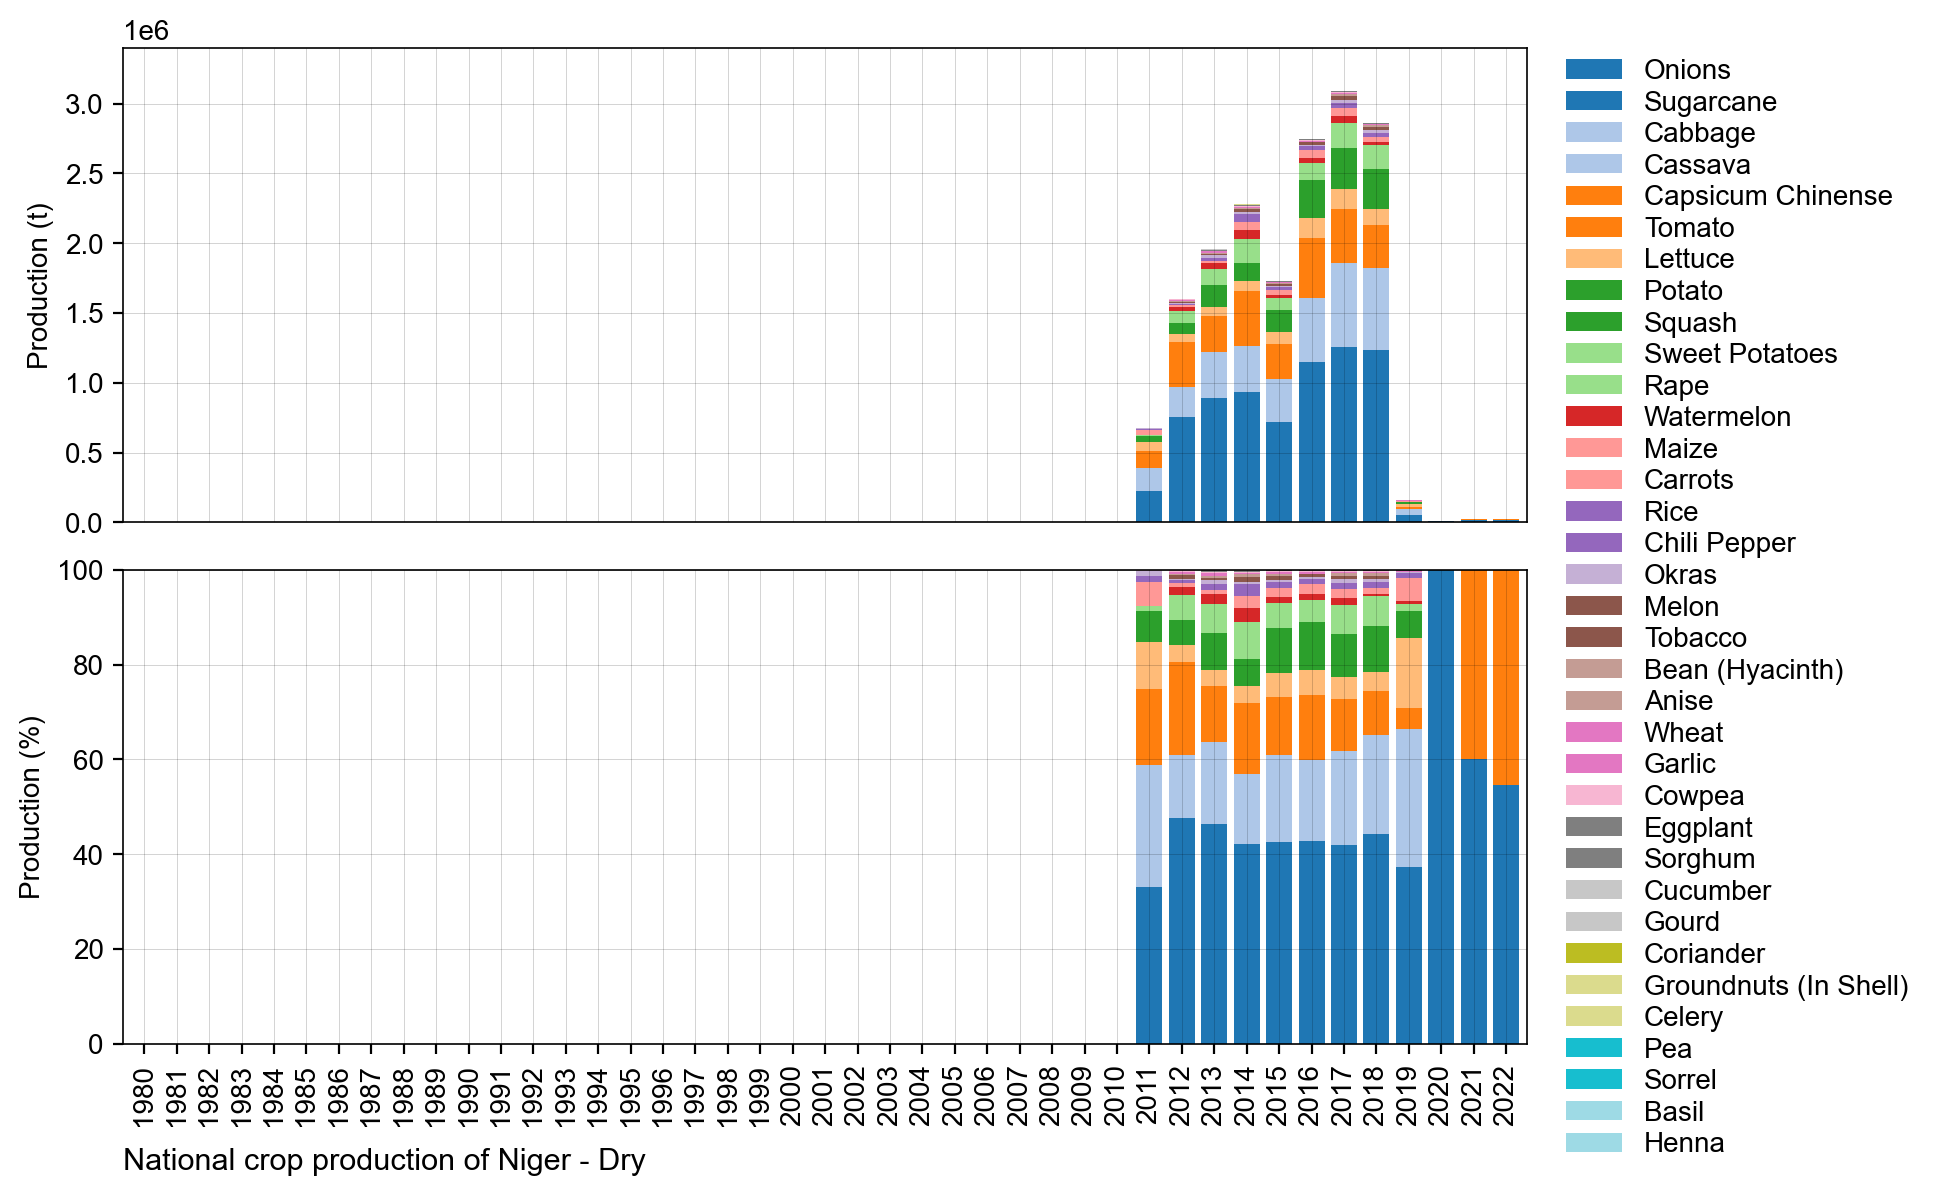

../figures/NE_bar_natgrainprod_Dry.png is saved.


In [9]:
# Bar chart of national crop production
country_iso, country_name = 'NE', 'Niger'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main', 'Dry']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

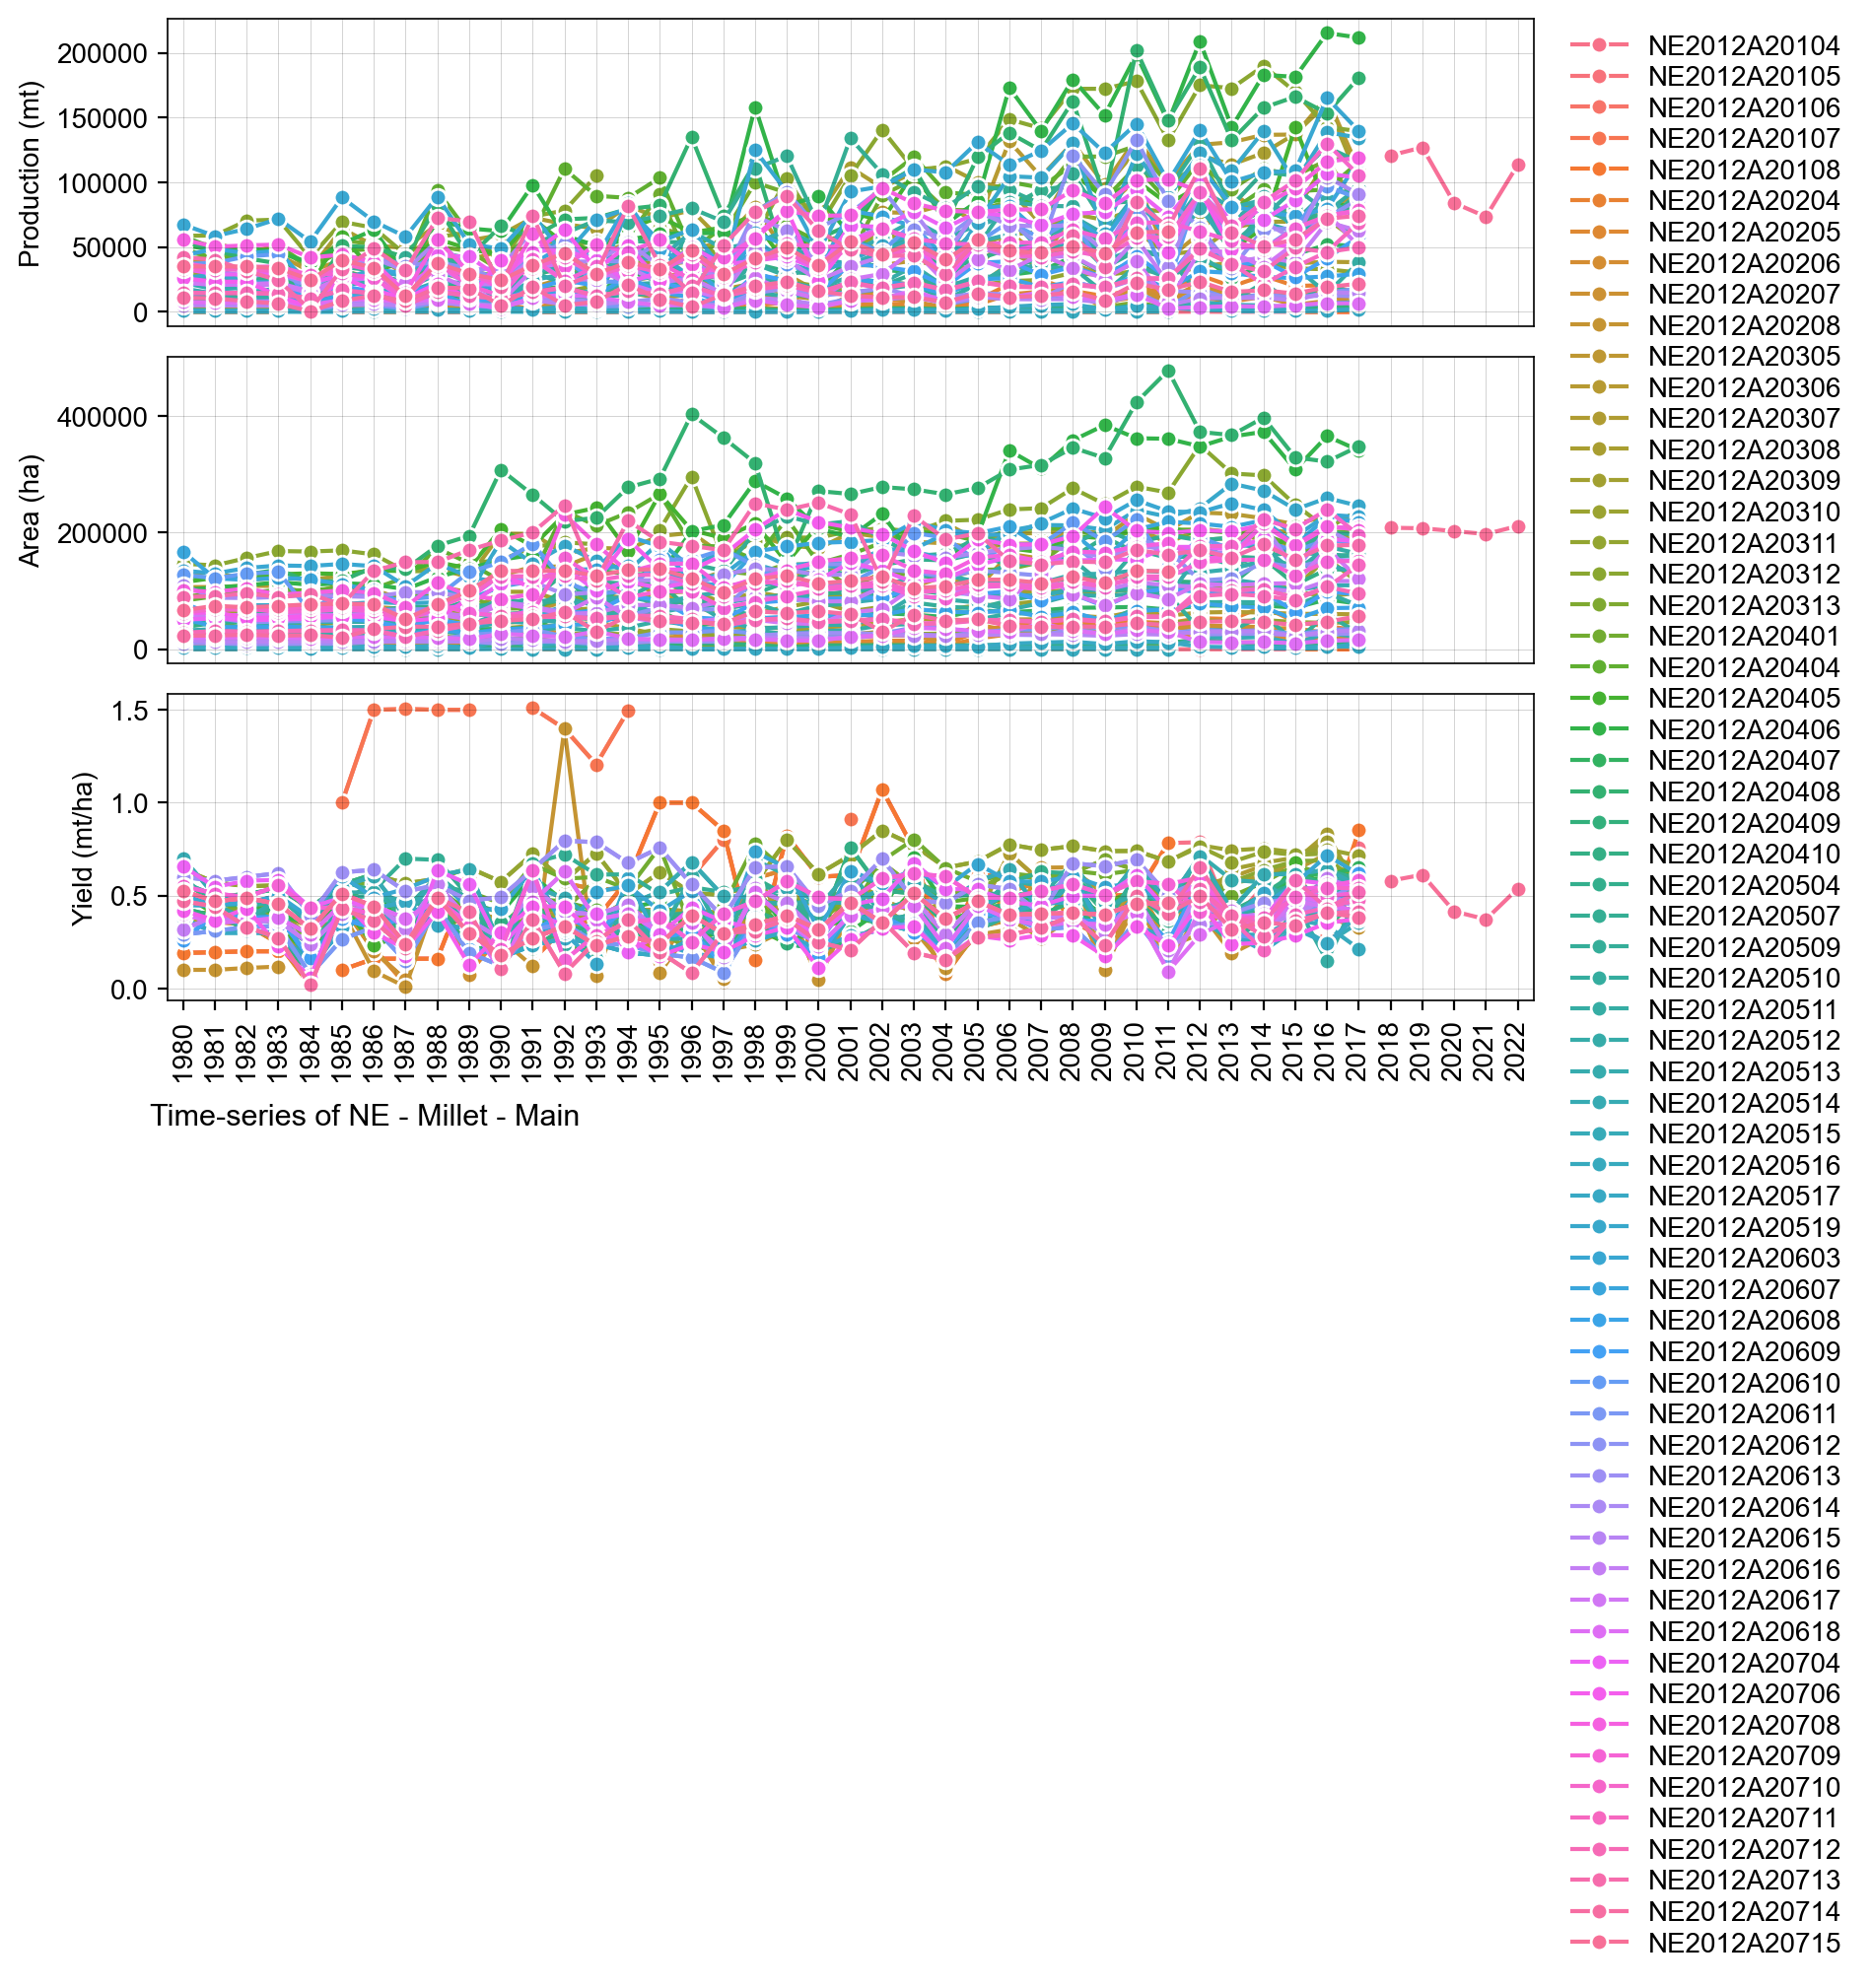

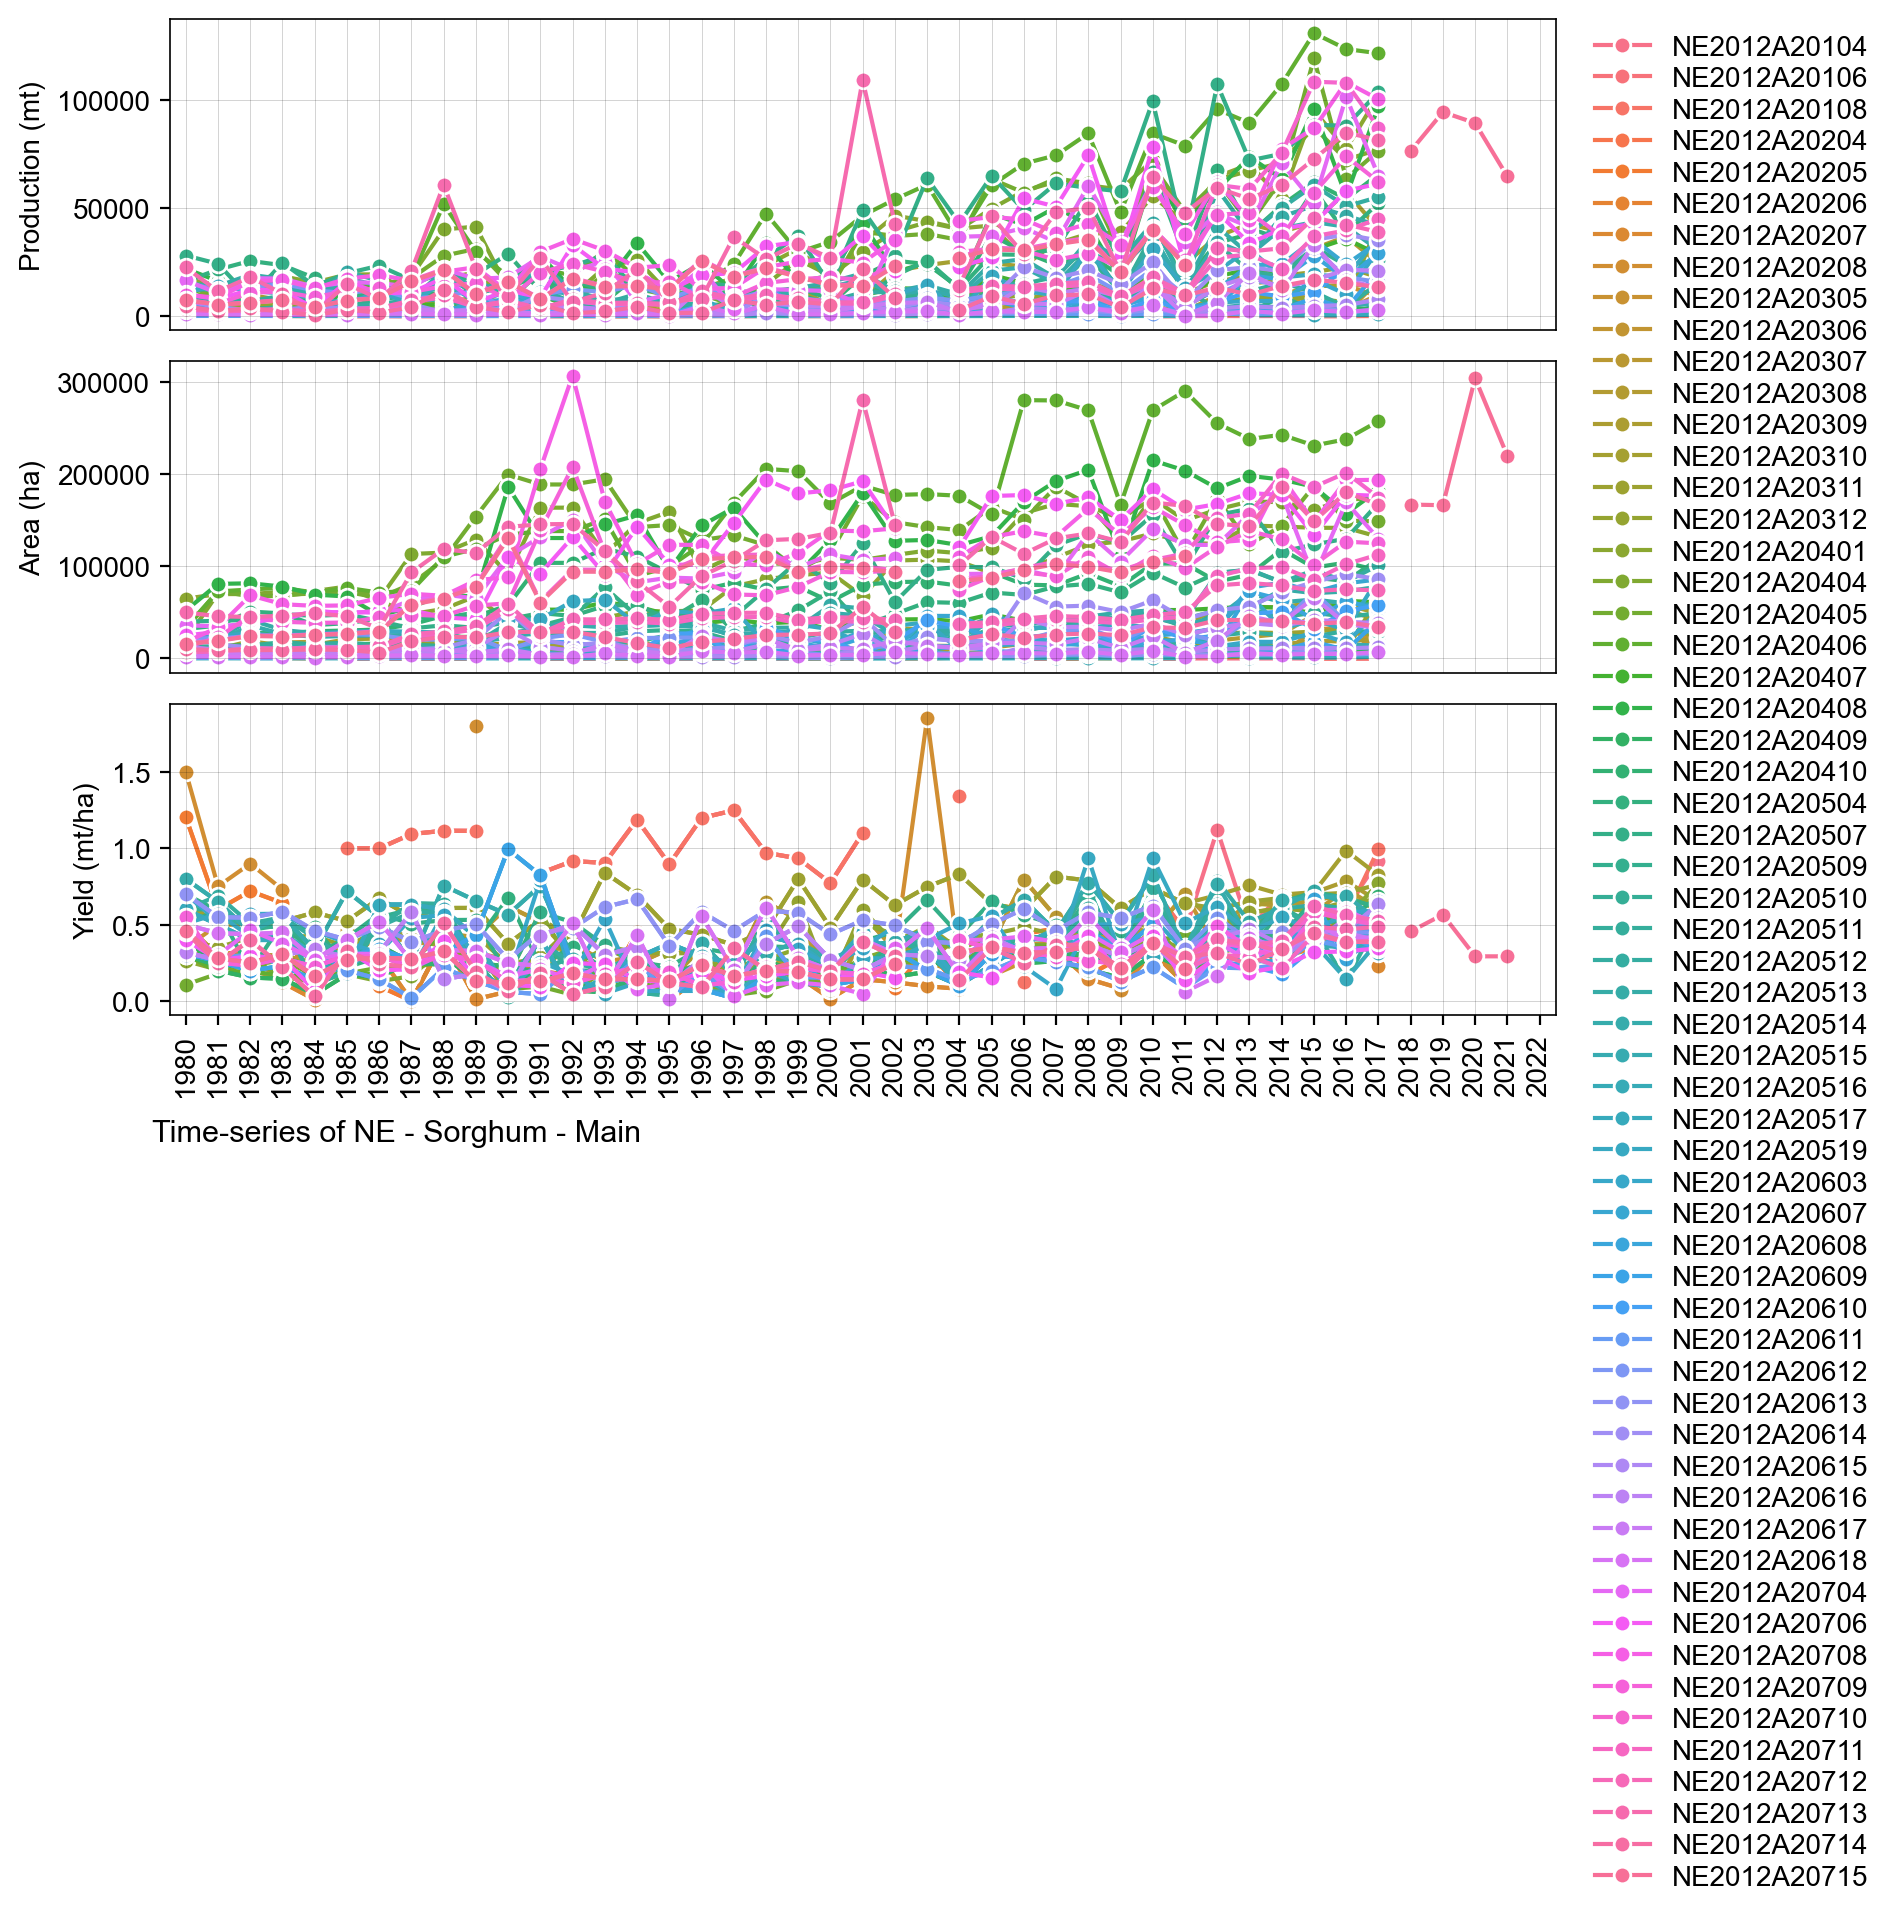

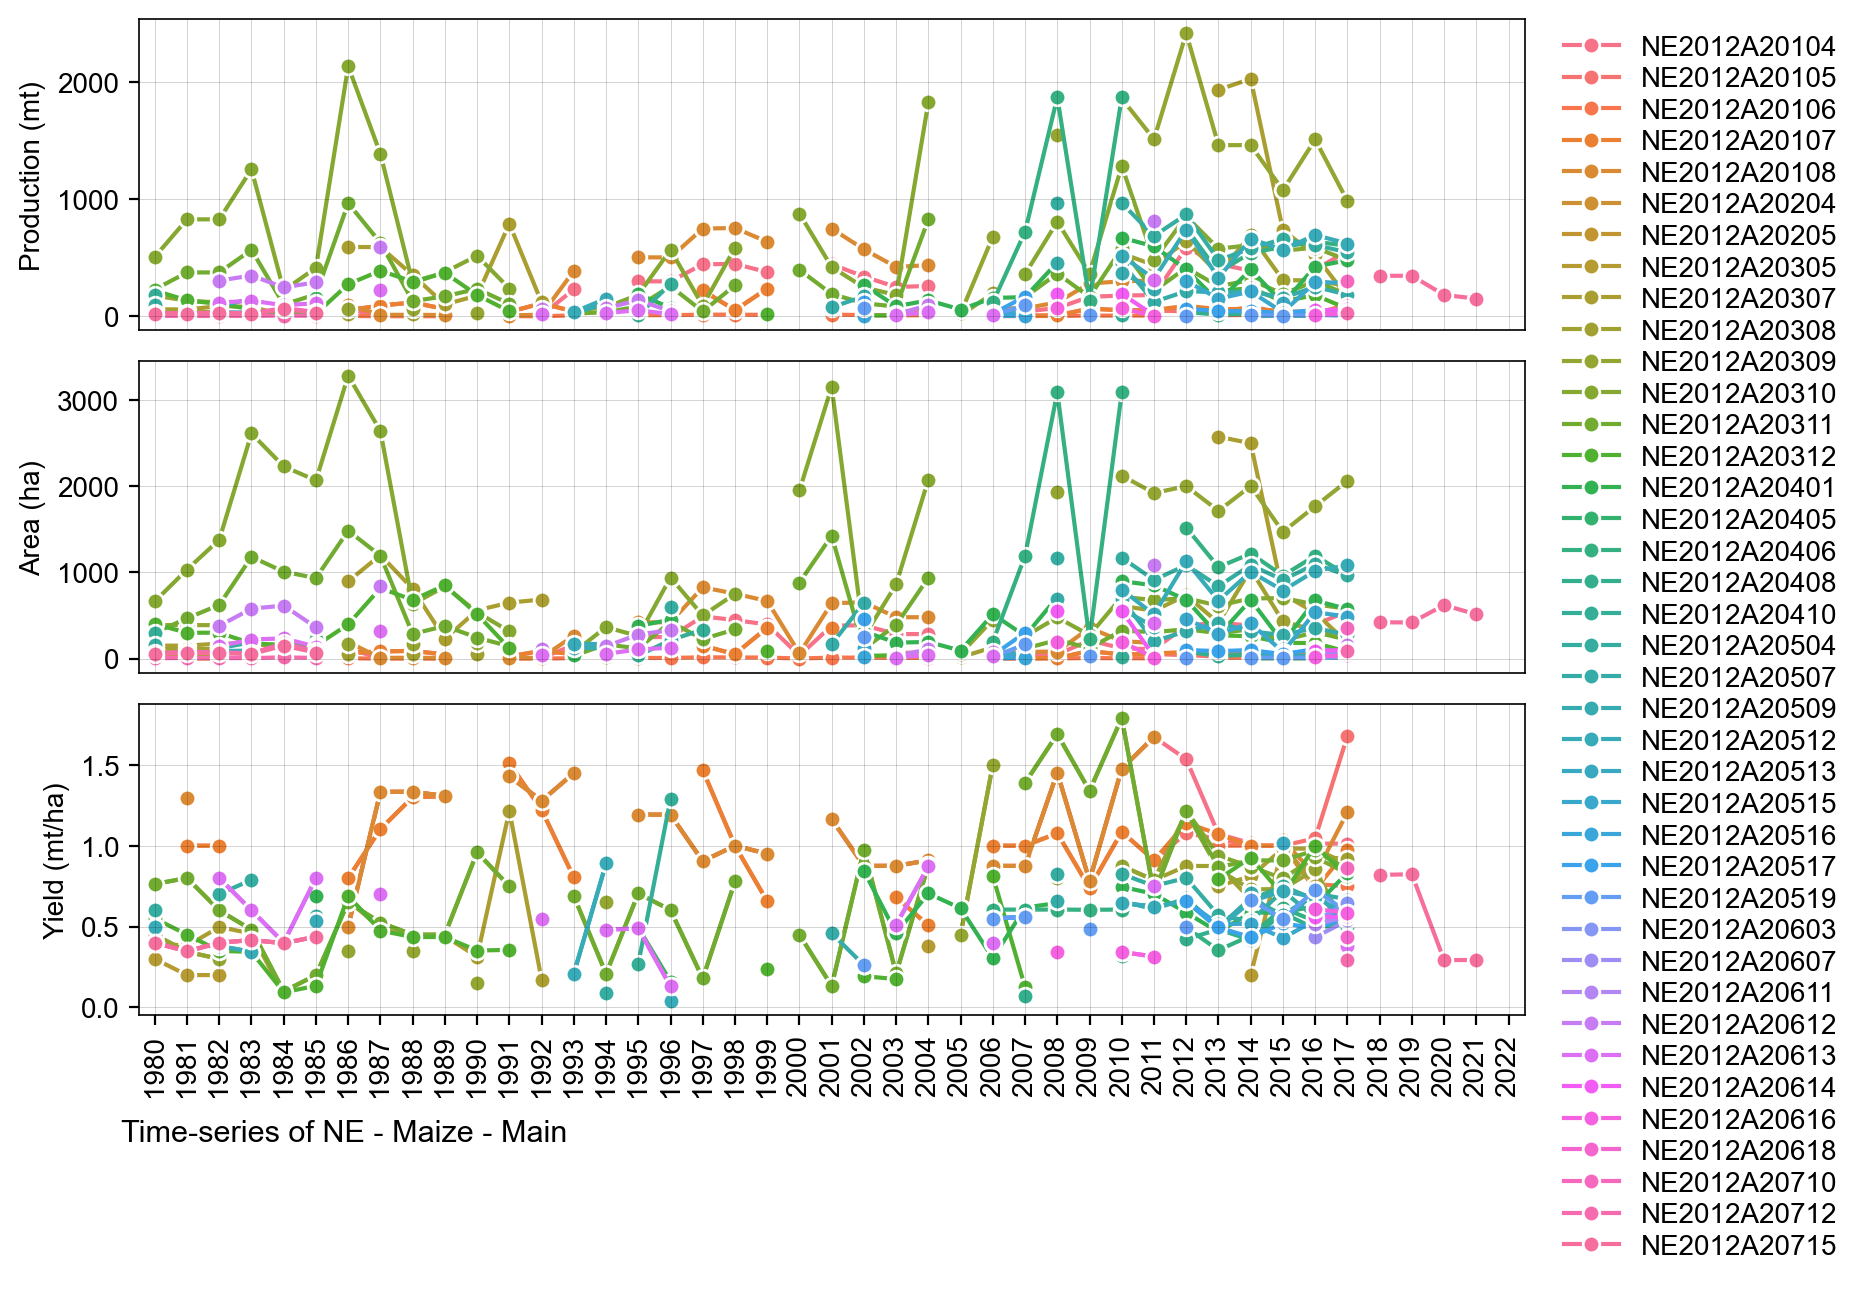

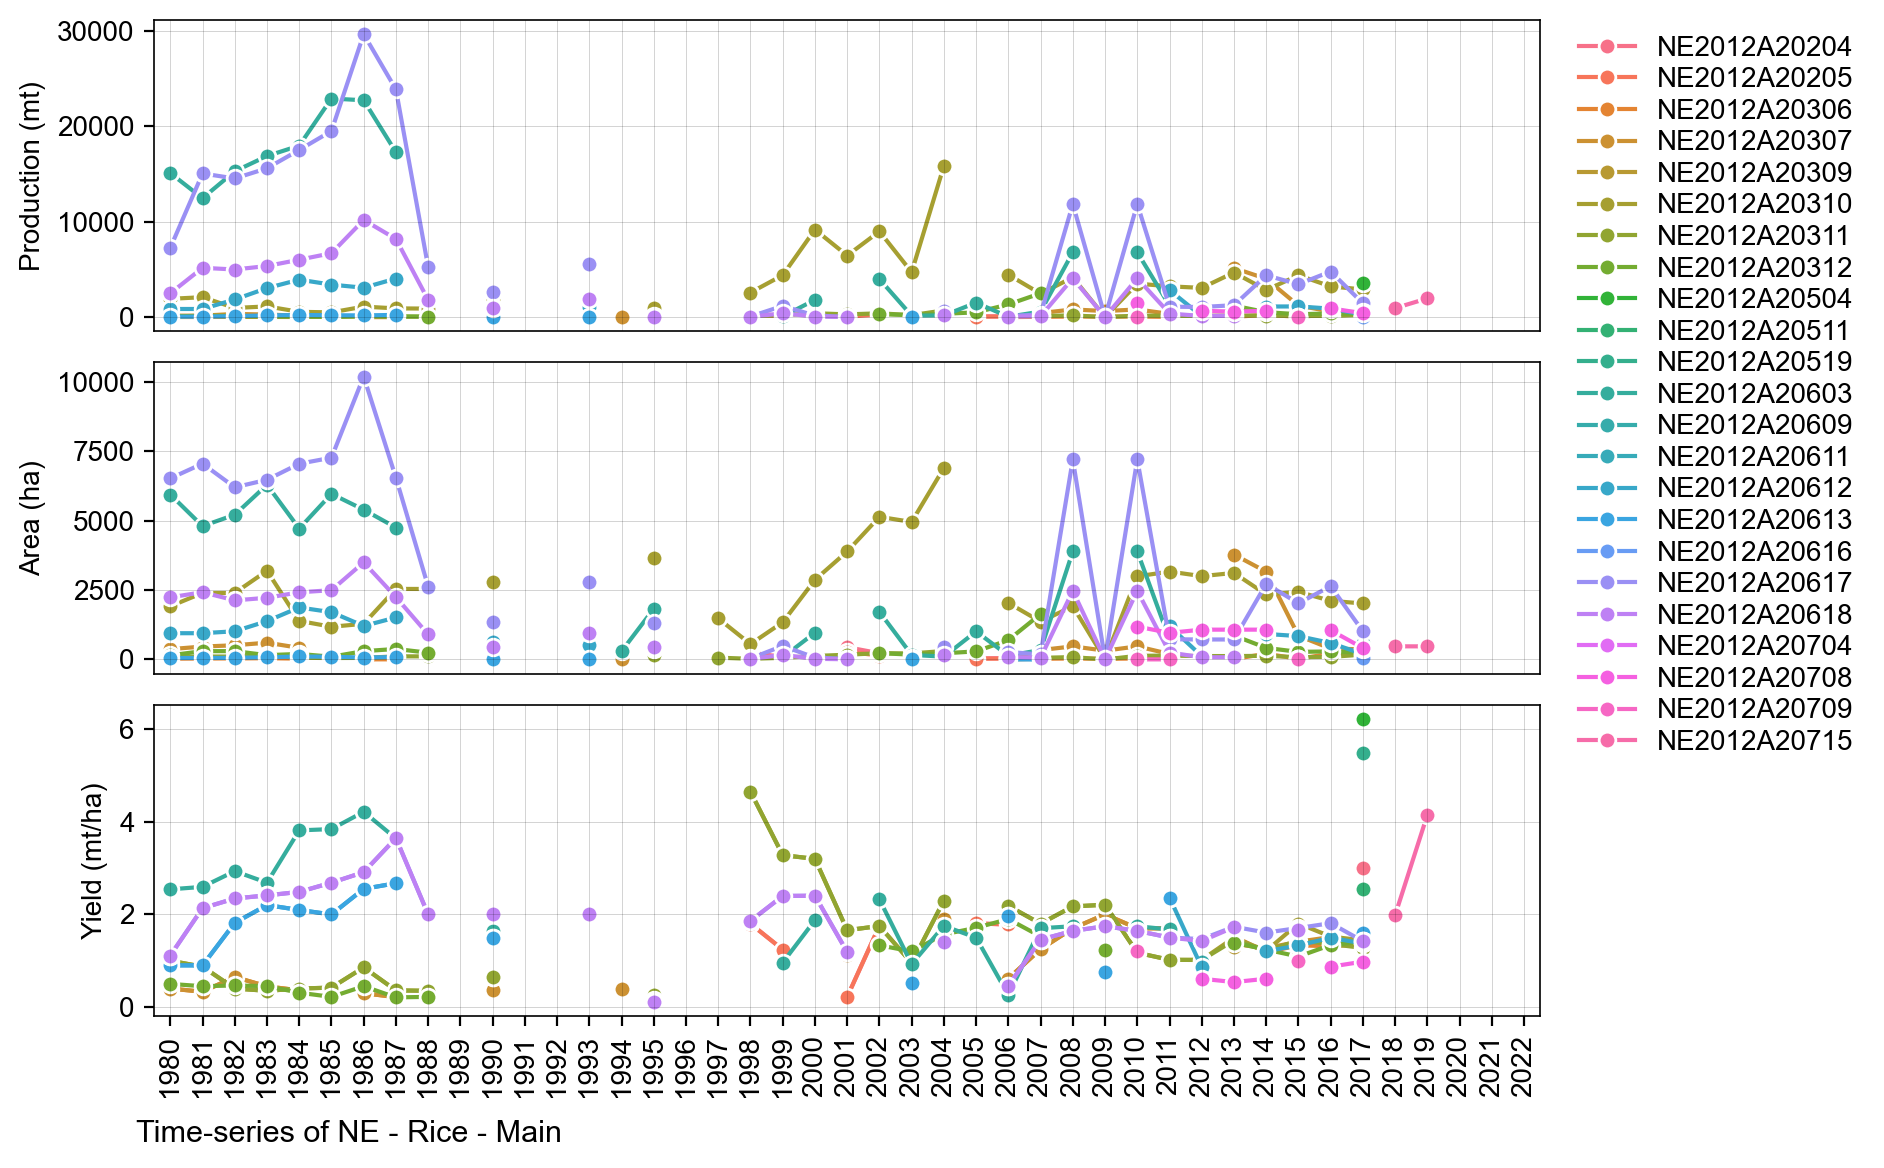

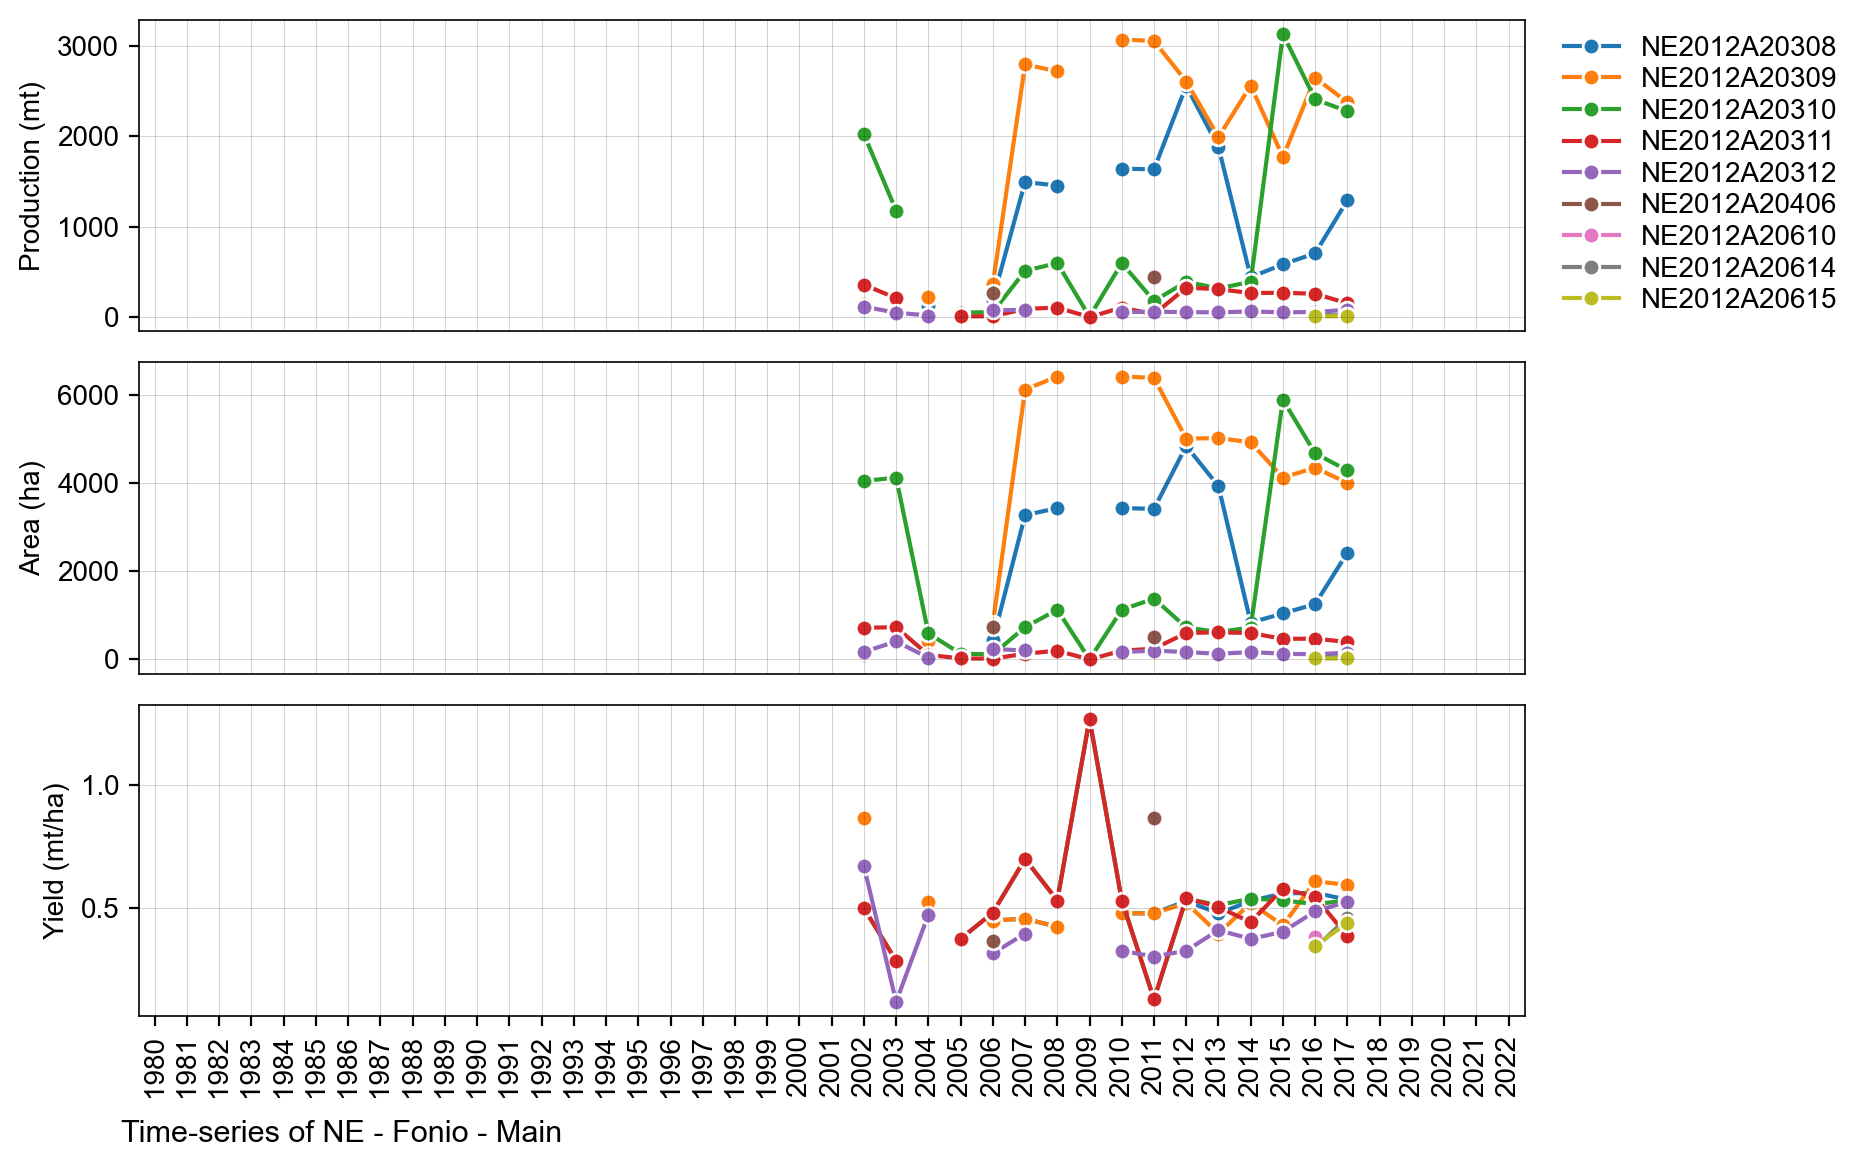

In [10]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'NE', 'Niger'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Millet','Main'],
    ['Sorghum','Main'],
    ['Maize','Main'],
    ['Rice','Main'],
    ['Fonio','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)